<a href="https://colab.research.google.com/github/vicentcamison/idal_ia3/blob/main/3%20Aprendizaje%20profundo%20(II)/Sesion%206/7_Time_series_prediction_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airline passenger prediction using LSTM in PyTorch

## Setup

In [9]:
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [3]:
flight_data = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv')
flight_data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
flight_data.shape

(144, 2)

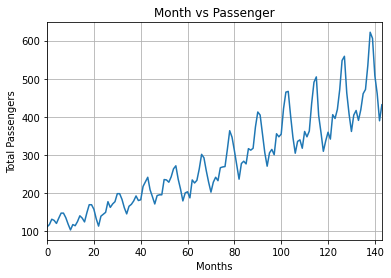

In [6]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['Passengers'])
plt.show()

# Preprocessing

In [14]:
dataset = np.array(flight_data)

# normalize the dataset between [0,1]
dataset[:, 1] = dataset[:, 1] / dataset[:,1].max()

# train/test split
two_thirds = dataset.shape[0] * 2 // 3
X_train = dataset[:two_thirds, 1]
X_test = dataset[two_thirds:, 1]

In [19]:
# Create dataset matrix using a time window of size "lag"

def create_dataset(input_data, lag):
    elements_no = input_data.shape[0]-lag-1
    dataX = np.zeros((elements_no, lag))
    dataY = np.zeros((elements_no))
    for i in range(elements_no):
      dataX[i, :] = input_data[i:i+lag]
      dataY[i] = input_data[i+lag]
    return torch.FloatTensor(dataX), torch.FloatTensor(dataY)

lag = 3

trainX, trainY = create_dataset(X_train, 3)
testX, testY = create_dataset(X_test, 3)


## Create LSTM model

In [44]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=128, output_size=1):
        super(LSTM,self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = self.hidden_layer_size)
        self.linear = nn.Linear(in_features=hidden_layer_size, out_features=output_size)
        self.hidden_cell = torch.zeros((1, 1, self.hidden_layer_size)), torch.zeros((1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1] #output for last timestep

In [45]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(lr=0.001, params=model.parameters())

In [46]:
print(model)

LSTM(
  (lstm): LSTM(1, 128)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)


## Train model

In [38]:
trainY.shape[1]

IndexError: ignored

In [39]:
trainX.shape[1]

3

In [31]:
trainX.view(trainX.shape[1], -1, 1).shape

torch.Size([3, 92, 1])

In [47]:
epochs = 150

for i in range(epochs):
    for seq, label in zip(trainX, trainY):
        optimizer.zero_grad()
        # reinicializamos los pesos
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)
        single_loss = loss_function(y_pred, label)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1: # print loss every 25 epochs
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   1 loss: 0.02489365
epoch:  26 loss: 0.01139595
epoch:  51 loss: 0.00104008
epoch:  76 loss: 0.00074230
epoch: 101 loss: 0.00070967
epoch: 126 loss: 0.00066806
epoch: 149 loss: 0.0006344623


## Predict

In [48]:
model.eval()

testPredict=[]
for i in range(len(testX)):
    with torch.no_grad():
      testPredict.append(model(testX[i,:]))

In [ ]:
# invert scaling
testPredict = scaler.inverse_transform(# completar)

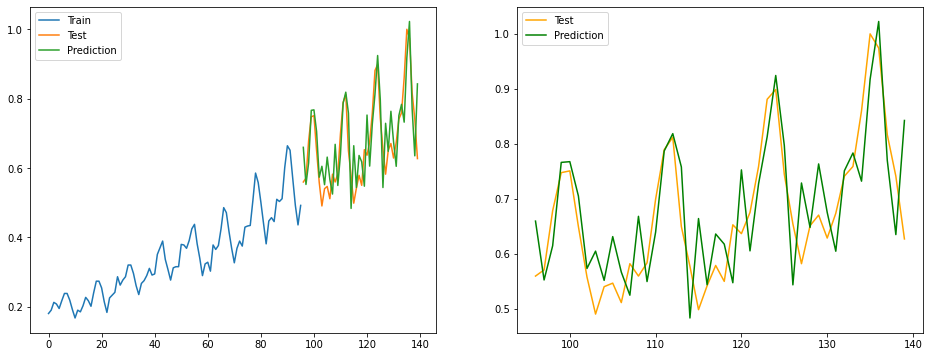

In [52]:
# plot baseline and predictions
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(X_train, label='Train')
plt.plot(range(len(X_train), len(X_train)+len(testY)), testY, label='Test')
plt.plot(range(len(X_train), len(X_train)+len(testPredict)), testPredict, label='Prediction')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(len(X_train), len(X_train)+len(testY)), testY, label='Test', c='orange')
plt.plot(range(len(X_train), len(X_train)+len(testPredict)), testPredict, label='Prediction', c='green')
plt.legend()
plt.show()